# A toy default risk model

## Dataset

In [7]:
#your name: Robin Wegmüller, Vladimir Solovyev, Wouter van Dijk
#your student number: 17-821-513, 21-743-620, 21-730-197

import numpy as np
import math


In [8]:
# EXERCISE 1

# We choose
J = 15000
K = 5000
num_samples = J+K

# draw random numbers for every feature
x_1 = np.random.uniform(low=18., high=80., size=(num_samples, 1))               #age
x_2 = np.random.uniform(low=1., high=15., size=(num_samples, 1))                #income (thousands)
x_3 = np.float32(np.random.uniform(low=0., high=1., size=(num_samples, 1)) < .1)#self-employed or employed 
# 'self-employed' corresponds to 1 and is supposed to hold for roughly 10% of the population
X = np.concatenate([x_1, x_2, x_3], axis=1)
X_J = X[:J, :]

# Compute the empirical means 
empirMean_J = np.mean(X_J, axis=0)
print('Empirical mean: age = ' + str(empirMean_J[0]))
print('Empirical mean: monthly income in CHF 1000 = ' + str(empirMean_J[1]))
print('Empirical mean: self-employed indicator = ' + str(empirMean_J[2]))    


Empirical mean: age = 48.95376975858977
Empirical mean: monthly income in CHF 1000 = 8.018233805860051
Empirical mean: self-employed indicator = 0.0976


In [9]:
# EXERCISE 2
sigmoid = lambda x: 1. / (1. + np.exp(-x))

# PART A

# Model parameters 
a_0 = -8.1
a_1 = 3.9
a_2 = -5.2
a_3 = 5.1

p_x = sigmoid(a_0 + a_1 * np.sqrt(np.absolute(x_1 - 55)) + a_2 * x_2 + a_3 * x_3)
y = np.float32(np.squeeze(np.random.uniform(size=(num_samples, 1)) < p_x))
print("Default rate {:.2f}%".format(np.mean(y[:J]) * 100.))

# Briefly comment on the case a_1 = a_2 = a_3 = 0 here:
# The case implies the constant function p(x)=p_const=sigmoid(a_0).
# Hence for every sample, the label for default is randomly selected from a Bern(p_const)
# experiment. Therefore, any model based on the features will have 0 predictive power out of sample.
# Based on this observation, the ROC curve will be theoretically diagonal for any model.
# Assuming of course that the test data is out of sample (to construct the ROC curve).

Default rate 4.87%


## Logistic regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss

# PART B

# divide dataset into train- and testset
X_train = X[:J, :]
X_test = X[J:, :]
y_train = y[:J]
y_test = y[J:]
p_test = p_x[J:]

# train logitic regression
model_LR = LogisticRegression().fit(X_train, y_train)

# calculate the scores from the logistic regression
scores_LR_train = model_LR.predict_proba(X_train)
scores_LR = model_LR.predict_proba(X_test)
# calculate total deviance for training and test data. 
# Note that scores_LR_train[:, 1] is the predicted default probability
print('total deviance for training data = ' + str(log_loss(y_train, scores_LR_train[:, 1])))
print('total deviance for test data = ' + str(log_loss(y_test, scores_LR[:, 1])))

total deviance for training data = 0.06783140243629884
total deviance for test data = 0.07266266096124104


In [11]:
# PART C
comp_LR = np.stack((scores_LR[:,1], y_test), axis=-1)
select = (comp_LR[:, 0] <= 0.04) & (comp_LR[:, 0] >= 0.03)
comp_LR_select = comp_LR[select, :]
print('fraction of y_j=1: ' + str( np.mean(comp_LR_select[:,1]) ) )

fraction of y_j=1: 0.12195121951219512


## Neural networks

In [12]:
# PART D

# Create and train neural network

import tensorflow as tf
from tensorflow import keras 

#build the nn model with 2 hidden layers
model_NN = keras.Sequential(
    [
     keras.layers.BatchNormalization(),
     keras.layers.Dense(32, activation='relu', name="hidden_layer_1"),
     keras.layers.Dense(32, activation='relu', name="hidden_layer_2"),
     keras.layers.Dense(1, activation='sigmoid', name="output_layer")
    ]
)

#the loss function
def total_deviance(y_true, y_pred):
    return tf.math.reduce_mean(-y_true * tf.math.log(y_pred) - (1. - y_true) * tf.math.log(1. - y_pred))

#pick an optimizer
model_NN.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=total_deviance
)

#shuffle the data during training
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, np.float32(y_train)))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(256)

#fit the model
model_NN.fit(
    train_dataset,
    batch_size=256,
    epochs=10
)



ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
#calculate the scores on the testdata
scores_NN_train = model_NN(X_train)
scores_NN = model_NN(X_test)

print('total deviance for training data = ' + str(log_loss(y_train, scores_NN_train)))
print('total deviance for test data = ' + str(log_loss(y_test, scores_NN)))

In [ ]:
# PART E

comp_NN = np.stack((scores_NN.numpy()[:,0], y_test), axis=-1)
select = (comp_NN[:, 0] <= 0.04) & (comp_NN[:, 0] >= 0.03)
comp_NN_select = comp_NN[select, :]
print('fraction of y_j=1: ' + str( np.mean(comp_NN_select[:,1]) ) )

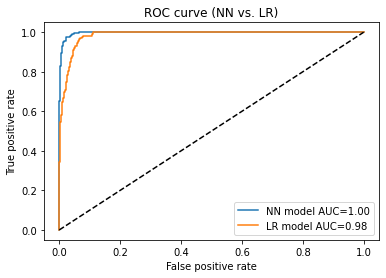

In [9]:
# ADDITIONAL - Plot of the ROC curve
from sklearn.metrics import roc_auc_score

fpr_LR, tpr_LR, thresholds_LR = metrics.roc_curve(y_test, scores_LR[:, 1], pos_label=1)
auc_LR = roc_auc_score(y_test, scores_LR[:, 1])
fpr_NN, tpr_NN, thresholds_NN = metrics.roc_curve(y_test, scores_NN[:, 0], pos_label=1)
auc_NN = roc_auc_score(y_test, scores_NN[:, 0])

plt.plot(fpr_NN, tpr_NN, label='NN model AUC={:.2f}'.format(auc_NN))
plt.plot(fpr_LR, tpr_LR, label='LR model AUC={:.2f}'.format(auc_LR))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (NN vs. LR)')
plt.legend(loc='best')

## P&L Analysis

In [10]:
# EXERCISE 3

# PART A

# Preliminary comment:
# The previous exercise shows that the NN model has a lower deviance compared to the logtistic regression.
# Hence we derive the 'good investment opportunities' using the NN model.

from scipy.stats import norm
import matplotlib as mpl

portfolio_size = K  # As stated in the exercise, we use features from the 'test' dataset (ie. x^j, j=J+1,...,J+K) -> that makes a portfolio of size K
loan_amount = 1000. 
rate = 0.04 # Given in the exercise: all the loans have an interest of 4%

# Simulate the defaults on the loan portfolio
# In order to have more robust results, we perform a Monte Carlo simulation with 50'000 simulations.  
# Remark: As stated in the exercise, we use features from the 'test' dataset (ie. x^j, j=J+1,...,K)
n_replic = 50000
defaults = np.float32(np.random.uniform(low=0., high=1., size=(portfolio_size, n_replic)) < p_test[:portfolio_size, :])  # select last K samples, which form the 'test' dataset

# Now that the defaults are defined, we split the implementation of the strategy to a different cell.
# This could allow us to run different analysis with the same defaults.

0.12373091779253631


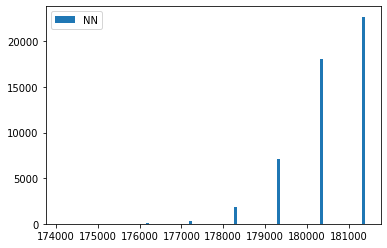

In [11]:
# PART A (continued)

# Description of the strategy:
# We lend money to everyone with a predicted default probability lower than 'threshold'.
# 'threshold' corresponds to a kind of hyperparameter:
#   - a lower value imply less defaults, but also limits the benefits, because some a priori good quality loans would not have been issued
#   - a high value makes it possible to have high returns, but increases the number of default loans that will be issues.  

# Using previous data, we can compute the in-sample default rate (defaultR_ins). 
# As we can see with the ROC curves, the large AUC indicate that we already have a very high true positive rate for very low false positive rate.
# Therefore, we could have defined the threshold as the (1-defaultR_ins)-quantile of the in-sample NN scores.
# However, in the context of the problem we are trying to solve, we have to be careful: it needs multiple performing loans (25) to compensate one non-performing loan.
# As seen below, the NN scores are heavily skewed: there is a range of values for which it is uncertain if the corresponding loan will default or not.
# In order to compensate for this uncertainty and the need to 'compensate' a loss by many perfoming loans, we look at the '1-c*defaultR_ins', where c>1 is an arbitrary constant.
# Based on the distribution of the data, multiple tests and the order of magnitude of the default rate (approx. 5%), we have identified c=2 as being relevant.
# Based on the distribution of the NN results and the previous problem-specific considerations, this coefficient seems intuitively.

defaultR_ins = np.mean(y[:J])
threshold = np.quantile(scores_NN_train, 1.-2*defaultR_ins)
# threshold = 0.2 # To compare to an arbitrary threshold
print(threshold)
p_and_l_NN = np.sum(loan_amount * (rate * (1. - defaults) - defaults) * np.float32(scores_NN < threshold), axis=0)

plt.figure(2)
plt.hist(p_and_l_NN, bins=100, label='NN')
plt.legend()

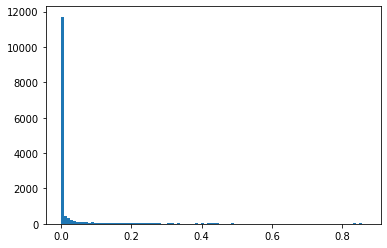

In [12]:
# ADDITIONAL - Visualizing the in-sample NN scores
plt.hist(scores_NN_train.numpy()[:,0], bins=100);

In [13]:
# PART B
# Compute the 'pct_VaR'%-VaR
pct_VaR=95
index = int(( (100-pct_VaR)*n_replic/100 )-1)
print('Expected P&L (NN): {:.2f}'.format(np.mean(p_and_l_NN)))

p_and_l_b_NN = np.sort(p_and_l_NN)
print('VaR (NN): {:.2f}'.format(-p_and_l_b_NN[index]))


Expected P&L (NN): 180582.28
VaR (NN): -179320.00


In [14]:
### To go one step beyond
# Here we optimized using in-sample data to minimize the amount of defaults. It results in a threshold of about 0.12
# This results in a significant difference in variance of the returns! Running this in the above result we also see that the Expected
# P&L is smaller, but that is even with perfectly fitting the threshold on the training data! So still looks quite robust.
from scipy.optimize import minimize
def to_opt(threshold):
  to_give_a_loan = scores_NN_train.numpy() < threshold
  pred_not_default = to_give_a_loan[to_give_a_loan] * 1 # Looks weird is correct
  # print(pred_not_default.shape)
  true_defaults = y_train[to_give_a_loan[:,0]]
  return np.absolute(np.average((pred_not_default - true_defaults) == 0))

res = minimize(to_opt, np.array(0.12), bounds=((0,1),), method="SLSQP", options={'eps':0.01})
print(res)


     fun: 7.377351530800442e-05
     jac: array([-3.35900562e-05])
 message: 'Optimization terminated successfully.'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0.12])


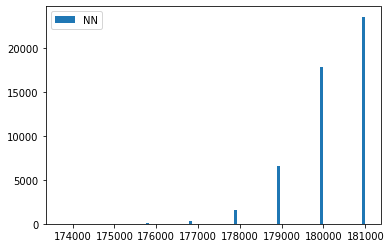

In [15]:
# Rerun the code to for the new threshold
p_and_l_NN = np.sum(loan_amount * (rate * (1. - defaults) - defaults) * np.float32(scores_NN < res.x), axis=0)

plt.figure(2)
plt.hist(p_and_l_NN, bins=100, label='NN')
plt.legend()

In [16]:
# Compute the 'pct_VaR'%-VaR
pct_VaR=95
index = int(( (100-pct_VaR)*n_replic/100 )-1)
print('Expected P&L (NN): {:.2f}'.format(np.mean(p_and_l_NN)))

p_and_l_b_NN = np.sort(p_and_l_NN)
print('VaR (NN): {:.2f}'.format(-p_and_l_b_NN[index]))

# As we can see from this run, the expected P&L is slightly lower and the VaR is worse as well.
# This is likely due to overfitting, but the difference is in our opinion economically small (< 1%).
# Hence, both aproaches lead to robust results and profits in this case study.

Expected P&L (NN): 180222.83
VaR (NN): -178920.00
